<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">K Artificial Neural Network Code</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

## Model making

### Imports

In [97]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm #Visualising exectuion progress

#for printing preatty
from markdown import markdown
from IPython.display import Markdown, HTML
from rich import print

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None

#To be able to show matplotlib graphs and results in this JupyterNotebook
get_ipython().run_line_magic('matplotlib', 'inline')

In [98]:
# Load the database using the second row as the name of the features
df=pd.read_excel(r'credit_cards.xls',engine='xlrd',header=1)

In [99]:
# After compiling this code, warnings will appear, it is normal and it will work regardless
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,confusion_matrix, recall_score,f1_score,brier_score_loss
from hmeasure import h_score

In [100]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

#Creathe the scaler object (from the sklearn.preprocessing module) used for standardizing features by removing the mean and scaling to unit variance
scaler=StandardScaler()

In [101]:
print(f"This is a snippet of the database being used")
display(df.head())
display(len(list(df.columns)))

This is a snippet of the database being used

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


25

### Model

In [102]:
# --------------------------------------------------------

# FIT THE MODEL AND EXTRACT NEW RESULTS

# --------------------------------------------------------
def get_scores(model,X_train, X_test,y_train,y_test):
    
    #train the network
    clas=model.fit(X_train,y_train,class_weight={0:0.2212,1:0.7788},epochs=300,verbose=0)  
    #print("-----Model fitted")
    #Get the predicted results
    y_pred=np.where(model.predict(X_test)>0.5,1,0)                                         
    y_pred1=model.predict(X_test)
    
    #Calculate metrics to measure success
    accuracy=accuracy_score(y_test,y_pred).round(2)
    auroc=roc_auc_score(y_test,y_pred)
    conf=confusion_matrix(y_test,y_pred)
    precision=precision_score(y_test,y_pred,pos_label=0)
    recall=recall_score(y_test,y_pred,pos_label=0)
    h=h_score(np.array(y_test),y_pred,pos_label=0)
    f1=f1_score(y_test,y_pred,pos_label=0)
    bs=brier_score_loss(y_test,y_pred1[:,0],pos_label=0)
    
    return accuracy,auroc,conf,precision,recall,f1,h,bs


In [103]:
# --------------------------------------------------------

# TRAIN THE MODEL AND EXTRACT RESULTS

# --------------------------------------------------------
def train_new_model(model,X,y,name = "ANN"):
    
    accuracy, auroc, precision, recall, f1, h, bs = [[] for _ in range(7)]
    conf=np.zeros([2,2])
    kfolds=10
    skf=StratifiedKFold(n_splits=kfolds)
    """
        - skf.split(X,y) splits the dataset into two parts, one for testing and the other for training
        - It spits out two arrays of indices.
        - Stratified sampling ensures that each fold of the dataset maintains the same 
          class distribution as the original dataset. It's especially useful when dealing 
          with imbalanced datasets where one class may be underrepresented.
    """
    for train_index, test_index in tqdm(skf.split(X, y)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_test=scaler.transform(X_test)
        
        # New Scores
        
        scores = get_scores(model,scaled_X_train, scaled_X_test,y_train,y_test)

        accuracy.append(scores[0])
        auroc.append(scores[1])
        conf += scores[2]
        precision.append(scores[3])
        recall.append(scores[4])
        f1.append(scores[5])
        h.append(scores[6])
        bs.append(scores[7])

    print(f"___________Model {name} fitted")
    
    dict_results = {"accuracy":accuracy,"auroc":auroc, "conf":conf, "precision":precision,
                   "recall":recall, "f1":f1,"h":h,"bs":bs, "kfolds":kfolds}
    
    return model, dict_results

In [104]:
# --------------------------------------------------------

# THESE FUNCTIONS WILL HELP US SAVE AND LOAD MODELS AND RESULTS

# --------------------------------------------------------
import pickle
import os
import json
        
def save_results(data,name = "results_full_ann", algo = 'ANN'):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, fr'{name}.json')
    
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
        
def load_results(name = "results_full_ann", algo = 'ANN'):
    doc_name = fr'models/{algo}/{name}.json'
    with open(doc_name, 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    return results

def save_model(model,name = "full_ann", algo = "ANN"):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    file_path = os.path.join(directory, fr'{name}.pkl')
        
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f'----------------------------Model Saved (Path: {file_path})-----------------------------')
    
def load_model(name = "full_ann", algo = "ANN"):
    doc_name = fr'models/{algo}/{name}.pkl'
    print(f"-----------------------------Model **{algo}** Found-----------------------------------------------------")
    with open(doc_name, 'rb') as file:
        model = pickle.load(file)
    print(f'-----------------------------Model Loaded (Path: {doc_name})-----------------------------')
    return model
        
        
def train_model(model, X, y, name = 'full_ann', algo = "ANN", recalculate = False):
    doc_name = fr'models/{algo}/{name}.pkl'
    # Check if the document exists in the folder
    if os.path.exists(doc_name) & (not recalculate):
        model = load_model(name,algo)
        dict_results = load_results(f"results_{name}",algo)
    else:
        print(f'----------------------------Model **{algo}** Not Found (Path: {doc_name})-----------------------------')
        print("Lets train the model!!")
        model, dict_results = train_new_model(model,X,y,name) 
        print(f'----------------------------Model **{algo}** Trained-----------------------------')
        save_model(model,name,algo)
        save_results(dict_results,f"results_{name}",algo)
        
    return model, dict_results

### Calibrate Model

In [108]:
#Sets up a neural network model using the Keras library
model=Sequential()                                                                      #create the network
model.add(Dense(5, input_dim=23,activation='sigmoid',kernel_initializer='he_uniform'))  #add a dense layer (fully connected) of 5 neurons wich has 24 input (expected features)
model.add(Dense(1, activation='sigmoid'))                                               #this is the layer used as the classifier
model.compile(loss='binary_crossentropy', optimizer='sgd',metrics='AUC')                #This line compiles the model, specifying the loss function, optimizer, and metrics to be used during training.

In [109]:
X_2 = X.iloc[:, 1:]
#display(X_2.head(4))

In [ ]:
recalculate = False
model_an, dict_results_an = train_model(model,X_2,y, 'full_ann_2', 'ANN', recalculate)

----------------------------Model **ANN** Not Found (Path: models/ANN/full_ann_2.pkl)-----------------------------

Lets train the model!!

0it [00:00, ?it/s]

94/94 [==============================] - 0s 859us/step


## Predictive performance tests

In [12]:
def get_results(dict_results):
    accuracy = dict_results["accuracy"]
    auroc = dict_results["auroc"]
    precision = dict_results["precision"]
    recall = dict_results["recall"]
    f1 = dict_results["f1"]
    conf = dict_results["conf"]
    h = dict_results["h"]
    bs = dict_results["bs"]
    kfolds = dict_results["kfolds"]
    
    return accuracy, auroc, precision, recall, f1, conf, h, bs, kfolds

def get_final_results(dict_results):
    accuracy = (np.array(dict_results["accuracy"])).mean()
    auroc = (np.array(dict_results["auroc"])).mean()
    precision = (np.array(dict_results["precision"])).mean()
    recall = (np.array(dict_results["recall"])).mean()
    f1 = (np.array(dict_results["f1"])).mean()
    conf = (dict_results["conf"]/dict_results["kfolds"]).round()
    h = (np.array(dict_results["h"])).mean()
    bs = (np.array(dict_results["bs"])).mean()
    kfolds = dict_results["kfolds"]
    
    return accuracy, auroc, precision, recall, f1, conf, h, bs, kfolds

In [13]:
an_accuracy, an_auroc, an_precision, an_recall, an_f1, an_conf, an_h, an_bs, an_kfolds = get_results(dict_results_an)
man_accuracy, man_auroc, man_precision, man_recall, man_f1, man_conf, man_h, man_bs, an_kfolds = get_final_results(dict_results_an)

In [14]:
#Brier Skill Score
bss=(1-(man_bs/1)).round(3)
#print(f'The Bruer Skill Score is {bss}')

s = f"""
<center>

| Model  | Accuracy | AUROC | Precision | Recall | F1 | H-measure | Brier Score | Brier Skill Score |
| ------------- | -------------| -------------| -------------| -------------| -------------| -------------| -------------| -------------|
| KNN   |  {man_accuracy:.3f} |  {man_auroc:.3f} |  {man_precision:.3f} |  {man_recall:.3f} |  {man_f1:.3f} |  {man_h:.3f} |  {man_bs:.3f} |  {bss:.3f} |

</center>
"""
print(f"Thise are the results of the Predictive Performance tests:")
html = markdown(s, extensions=["tables"])
display(HTML(html))

Thise are the results of the Predictive Performance tests:

Model,Accuracy,AUROC,Precision,Recall,F1,H-measure,Brier Score,Brier Skill Score
KNN,0.766,0.707,0.877,0.816,0.845,0.000,0.425,0.575


In [15]:
# Confusion Matrix
s = f"""
<center>

|    | Yes | No |
| ------------- | -------------| -------------| 
| Yes   |  {man_conf[0][0]} |  {man_conf[0][1]} |
| No   |  {man_conf[1][0]} |  {man_conf[1][1]} |

</center>
"""

print(f"Thise are the results of the Confucion Matrix tests:")
html = markdown(s, extensions=["tables"])
display(HTML(html))

Thise are the results of the Confucion Matrix tests:

,Yes,No
Yes,1907.0,430.0
No,266.0,397.0


## Interpretability

### SHAP

#### Calculate SHAP values

In [16]:
# Train one instance of the model with 0.8 of the data
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

#Sets up a neural network model using the Keras library
model=Sequential()                                                                      #create the network
model.add(Dense(5, input_dim=24,activation='sigmoid',kernel_initializer='he_uniform'))  #add a dense layer (fully connected) of 5 neurons wich has 24 input (expected features)
model.add(Dense(1, activation='sigmoid'))                                               #this is the layer used as the classifier
model.compile(loss='binary_crossentropy', optimizer='sgd',metrics='AUC')                #This line compiles the model, specifying the loss function, optimizer, and metrics to be used during training.

In [17]:
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def get_prediction(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaled_X_train=scaler.fit_transform(X_train)
    scaled_X_test=scaler.transform(X_test)
    y_pred=np.where(model.predict(scaled_X_test)>0.5,1,0)                                         
    return y_pred

In [18]:
import shap
from sklearn.model_selection import train_test_split
def SHAP_model_training(model,X,y,name,algo = "ANN"):
    doc_name = fr'models/{algo}/{name}.json'
    
    if os.path.exists(doc_name) & (not recalculate):
        shap_values = load_results(name,algo)
    else:
        print(f"-----------SHAP values for {algo} not found, START CALCULATION-------------")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)        
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_test=scaler.transform(X_test)

        
        x_sub = shap.sample(scaled_X_train,100)
        explainer = shap.Explainer(model, x_sub)
        shap_values = explainer(scaled_X_test)
        #shap.plots.beeswarm(shap_values[:,:])

        print("SHAP Values fitted")
        save_results(shap_values,name,algo)
    print(f"-----------SHAP values for {algo} FOUND and LOADED -------------")
    return shap_values

In [27]:
shap_values = SHAP_model_training(model, X, y,"shap_an","ANN")

-----------SHAP values for ANN FOUND and LOADED -------------

#### Explore SHAP values

In [37]:
shap_values[0]

.values =
array([ 0.020762  ,  0.0854352 ,  0.01825733, -0.00262647, -0.02450924,
       -0.00268491, -0.08525197, -0.00568547, -0.00342745, -0.00052224,
       -0.00893705, -0.0098064 ,  0.00177666, -0.02593494, -0.01661579,
        0.00413303,  0.01076449, -0.00192078,  0.01647835,  0.01299376,
        0.00563988, -0.00050236,  0.0047784 ,  0.00269116])

.base_values =
array([0.46617426])

.data =
array([-1.46330554, -1.05776818, -1.23738094,  0.18430622,  0.85811358,
       -1.13637372,  0.01479575,  0.10969398,  0.14111968,  0.18869959,
        0.23405483,  0.25057055, -0.57307716, -0.54782383, -0.50785801,
       -0.47501805, -0.43596106, -0.4037658 , -0.24413577, -0.16311826,
       -0.20601893, -0.20735823, -0.21248658, -0.18097254])

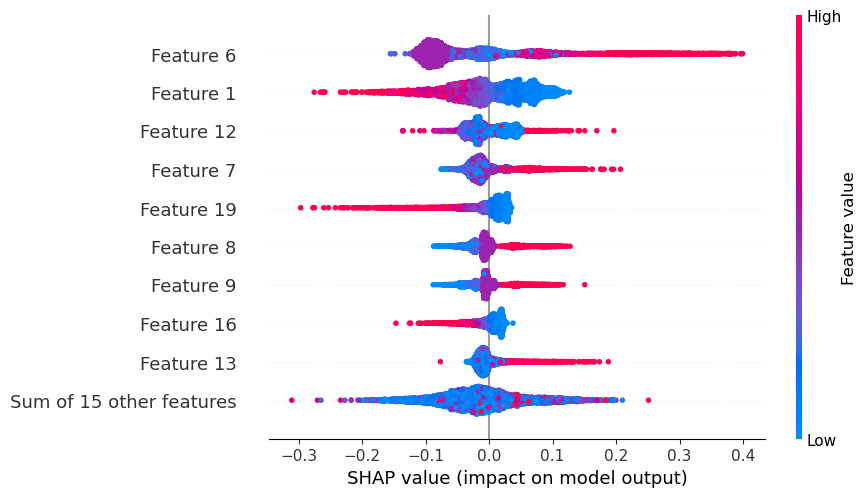

In [71]:
shap.plots.beeswarm(shap_values_svm[:,:])

In [34]:
def whaterfall_plot(shap_values,X_test,index = 0,max_display = 10):
    shap_val_0 = shap_values[index, :]
    shap_val_0.data = X_test.iloc[index]
    shap.plots.waterfall(shap_val_0, max_display = max_display)
    shap.plots.bar(shap_val_0, max_display = max_display)

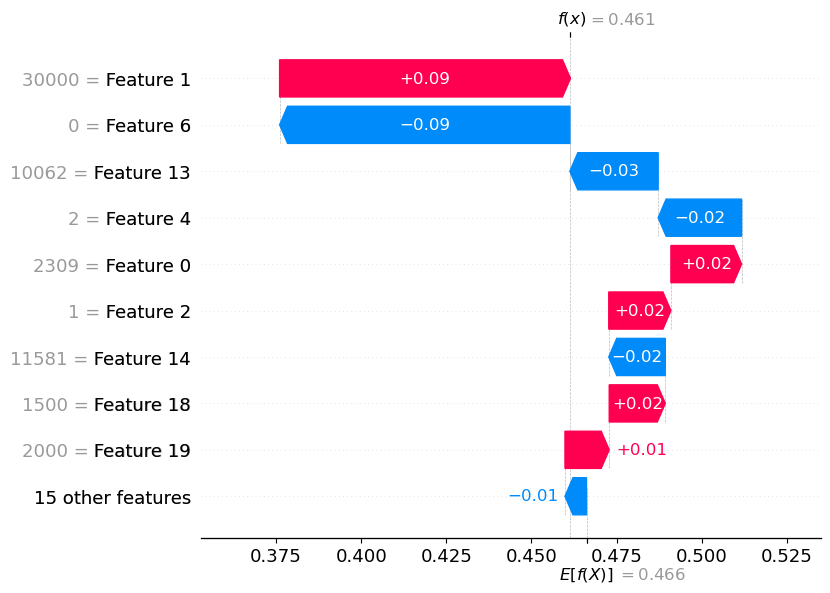

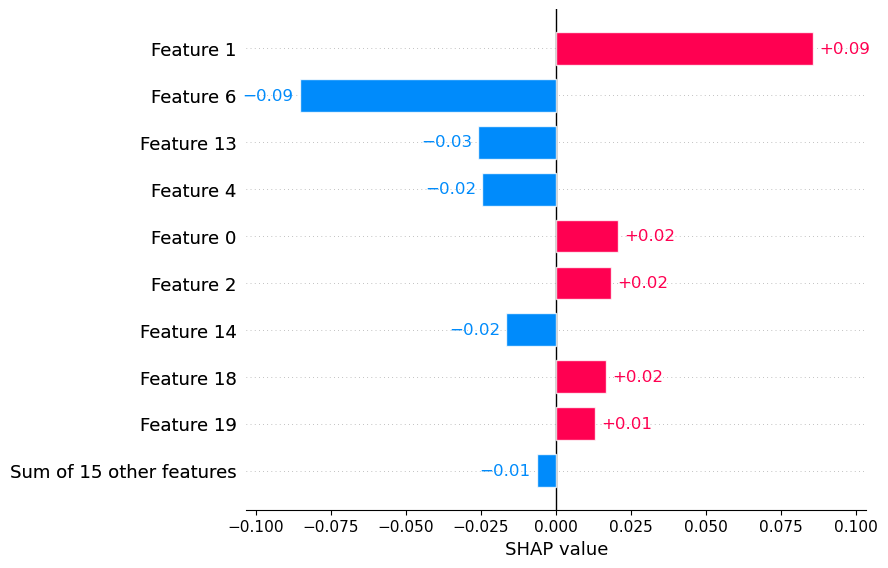

After seing this plot, I have concluded that the variable 'ID' should not be used therefore, all calculations must 
be remade
This is one of the thing why XAI is so important, to be able to see where our model is taking unwanted viases.
Another thing to look for is whether sex or age play a big role in the predicions

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)

whaterfall_plot(shap_values,X_test,0)
print("")
print("""
After seing this plot, I have concluded that the variable 'ID' should not be used therefore, all calculations must be remade
This is one of the thing why XAI is so important, to be able to see where our model is taking unwanted viases.
Another thing to look for is whether sex or age play a big role in the predicions
""")

In [88]:
shap_values[:,0]

.values =
array([ 0.020762  , -0.00068963, -0.00206993, ..., -0.00175377,
        0.00274356,  0.00143204])

.base_values =
array([0.46617426, 0.46617426, 0.46617426, ..., 0.46617426, 0.46617426,
       0.46617426])

.data =
array([-1.46330554,  0.85184175,  0.9662397 , ...,  0.93294564,
        1.23190101,  1.63142981])

In [89]:
shap.plots.scatter(shap_values[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

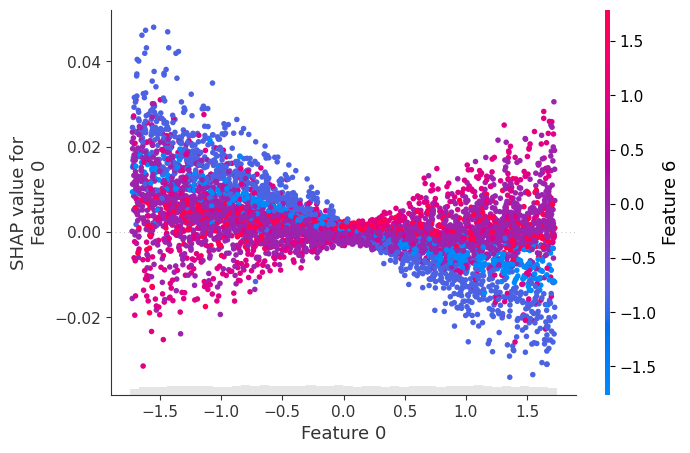

In [59]:
shap.plots.scatter(shap_values[:,0],color = shap_values[:])

### LIME

<table style="width: 100%;">
  <tr>
      <td style="text-align: left;"><td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>